# ID The Composer Algorithm
##A Deep Learning Neural Network for Composer Identification

###Overview & Goals
This code is designed to ingest music files to train deep learning models in order to identify the composer based on the music alone. The primary objective is to develp a deep learnign model that can predict the composer of a given musical score accurately.

The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

This project is part of the Master's In Applied Artificial Intelligence program at the University of San Diego.

###Methodology for this Project
1. Data Collection (data provided via kaggle, workflow via Google Drive)
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.




#Data Download

In [1]:
!pip install kaggle
!pip install pretty_midi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=bffc8e5b07503a3218055266b3349802c517008db2cfaef96f13d6c5d4b0744e
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
# ===== Standard Library =====
import os
import re
import ast
import random
import shutil
import zipfile
from zipfile import ZipFile
import warnings
from itertools import cycle

# ===== Third-Party Libraries =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import mido
import pretty_midi
import pretty_midi as pm
import kagglehub as kagglehub  # Wire to Kaggle?

# ===== Scikit-learn =====
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, average_precision_score
)

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [3]:
#Set desired file path
IS_GOOGLE_COLAB = True
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
DATASET_ID = "blanderbuss/midi-classic-music"
MIDI_DATA_DIR = '/content/midi_data'
DESTINATION_DIR = "/tmp"
SOURCE_DATA_DIR = DESTINATION_DIR
SUPPORTED_EXT = ['.mid', '.midi']

if IS_GOOGLE_COLAB == False:
    MIDI_DATA_DIR = os.path.join(os.getcwd(), 'midi_data')

In [4]:
#Set universal random seed for codeset
SEED = 42

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(SEED)

In [5]:
# ----------------------------------
# Delete a folder and all its contents
# ----------------------------------
def delete_folder_recursive(folder_path):

    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)
            print(f" Deleted folder and its contents: {folder_path}")
        except Exception as e:
            print(f"[ERROR] Failed to delete {folder_path}: {e}")
    else:
        print(f"[INFO] Folder does not exist: {folder_path}")

delete_folder_recursive("/content/midi_data")

[INFO] Folder does not exist: /content/midi_data


In [6]:
# -------------------------------
# Download Dataset via KaggleHub
# -------------------------------
def download_dataset(dataset_id):
    print(f"Downloading dataset: {dataset_id}")
    dataset_path = kagglehub.dataset_download(dataset_id)
    print(f"Dataset downloaded to temporary path: {dataset_path}")
    return dataset_path

# -------------------------------
# Copy Dataset to Destination
# -------------------------------
def copy_dataset(source_path, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Created destination folder: {destination_path}")

    try:
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
        print(f"Dataset copied from '{source_path}' to '{destination_path}'")
    except Exception as e:
        print(f"[ERROR] Could not copy dataset: {e}")

# ----------------------------------
# Create base output folder and composer folders
# ----------------------------------
def create_composer_folders(base_dir, composers):
    os.makedirs(base_dir, exist_ok=True)
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        os.makedirs(composer_dir, exist_ok=True)

# ----------------------------------
# Recursively extract all .zip files in a directory
# ----------------------------------
def extract_all_nested_zips(base_path):
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith('.zip'):
                zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(zip_path)[0]
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                        #print(f"Extracted: {zip_path} -> {extract_path}")
                except zipfile.BadZipFile:
                    print(f"[WARNING] Skipped invalid ZIP: {zip_path}")
                    continue
                except Exception as e:
                    print(f"[ERROR] Failed to extract {zip_path}: {e}")
                    continue
                # Recursively extract deeper levels
                extract_all_nested_zips(extract_path)

# ----------------------------------
# Copy .midi files to composer folders
# ----------------------------------
def copy_midi_files_to_composer_folders(source_dir, target_dir, composers):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                full_path = os.path.join(root, file)
                for composer in composers:
                    if composer.lower() in full_path.lower():
                        destination = os.path.join(target_dir, composer, file)
                        try:
                            shutil.copy2(full_path, destination)
                            #print(f"Copied: {full_path} -> {destination}")
                        except Exception as e:
                            print(f"[ERROR] Failed to copy {full_path}: {e}")
                        break

# ----------------------------------
# Orchestrator function
# ----------------------------------
def organize_midi_data():
    # Step 1: Create output structure
    create_composer_folders(MIDI_DATA_DIR, composers)

    # Step 2: Extract all ZIPs (even nested)
    extract_all_nested_zips(SOURCE_DATA_DIR)

    # Step 3: Copy relevant .midi files to target composer folders
    copy_midi_files_to_composer_folders(SOURCE_DATA_DIR, MIDI_DATA_DIR, composers)

# ----------------------------------
# Print summary of .mid/.midi files per composer
# ----------------------------------
def print_midi_file_summary(composer_dir, composers):
    summary = {}

    for composer in composers:
        folder_path = os.path.join(composer_dir, composer)
        count = 0

        # Count .mid and .midi files only
        for file in os.listdir(folder_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in SUPPORTED_EXT:
                count += 1

        summary[composer] = count

    print("\n MIDI File Summary per Composer:")
    print("----------------------------------")
    for composer, count in summary.items():
        print(f"{composer}: {count} files")

# -------------------------------
# Full Setup Pipeline
# -------------------------------
def setup_dataset():
    source = download_dataset(DATASET_ID)
    copy_dataset(source, DESTINATION_DIR)
    organize_midi_data()


setup_dataset()
print_midi_file_summary(MIDI_DATA_DIR, composers)

Dataset downloaded to temporary path: /kaggle/input/midi-classic-music
Dataset copied from '/kaggle/input/midi-classic-music' to '/tmp'

 MIDI File Summary per Composer:
----------------------------------
Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files


## **Data Pre-Processing & Feature Extraction**

In [7]:
def get_composer_midis(base_dir, composers, supported_ext=('.mid', '.midi')):
    """
    Finds MIDI file paths for selected composers in base_dir and returns a DataFrame and a dict mapping composers to their files.

    Args:
        base_dir (str): Path to search.
        composers (list): List of composer names (strings).
        supported_ext (tuple): Tuple of allowed file extensions.

    Returns:
        df (pd.DataFrame): DataFrame of matching files and composers.
        composer_files (dict): Dict of composer name to list of filepaths.
    """
    matched_paths = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            if file_path.lower().endswith(supported_ext):
                for composer in composers:
                    if composer.lower() in file_path.lower():
                        matched_paths.append({'filepath': file_path, 'composer': composer})
                        break  # Only assign first matching composer

    # Create DataFrame
    df = pd.DataFrame(matched_paths)
    pd.set_option('display.max_colwidth', None)

    # Drop any rows where composer is not found (shouldn't happen here, but kept for safety)
    df = df.dropna(subset=['composer'])

    # Collect filepaths for each composer
    composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

    # Print stats
    for composer, files in composer_files.items():
        print(f"{composer}: {len(files)} files")

    return df, composer_files


df, composer_files = get_composer_midis(MIDI_DATA_DIR, composers)
print(df)

Bach: 1050 files
Beethoven: 220 files
Chopin: 138 files
Mozart: 259 files
                                                                       filepath  \
0                       /content/midi_data/Mozart/K317 Coronation Mass 6mov.mid   
1                      /content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid   
2              /content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid   
3              /content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid   
4                           /content/midi_data/Mozart/Piano Sonata n07 K309.mid   
...                                                                         ...   
1662       /content/midi_data/Beethoven/Sonata No.14 Op 27 Moonlight Sonata.mid   
1663                 /content/midi_data/Beethoven/Piano Sonatina No.2 Op 49.mid   
1664                         /content/midi_data/Beethoven/Bagatella op33 n4.mid   
1665               /content/midi_data/Beethoven/Symphony n3 4mov ''Eroica''.mid   
1666  /conten

In [8]:
df.head()

,filepath,composer
0,/content/midi_data/Mozart/K317 Coronation Mass 6mov.mid,Mozart
1,/content/midi_data/Mozart/K309 Piano Sonata n10 2mov.mid,Mozart
2,/content/midi_data/Mozart/K608 Fantasia for Mechanical Organ.mid,Mozart
3,/content/midi_data/Mozart/Symphony n41 K551 2mov ''Jupiter''.mid,Mozart
4,/content/midi_data/Mozart/Piano Sonata n07 K309.mid,Mozart


In [9]:
def balance_bach_dataset(df, bach_name='Bach', seed=42, bach_frac=0.6):
    """
    Downsample Bach's entries while keeping other composers' data intact.

    Args:
        df (pd.DataFrame): DataFrame with at least 'composer' column.
        bach_name (str): Name of the composer to downsample.
        seed (int): Random seed for reproducibility.
        bach_frac (float): Fraction of Bach's data to keep.

    Returns:
        pd.DataFrame: Balanced and shuffled DataFrame.
    """
    # Downsample Bach
    df_bach = df[df['composer'] == bach_name].sample(frac=bach_frac, random_state=seed)

    # Keep all others but shuffle them
    df_others = (
        df[df['composer'] != bach_name]
        .groupby('composer', group_keys=False)
        .sample(frac=1, random_state=seed)
    )

    # Combine and shuffle
    df_sampled = pd.concat([df_bach, df_others]).reset_index(drop=True)
    df_sampled = df_sampled.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print(f"Total files after balancing: {len(df_sampled)}")
    return df_sampled

df = balance_bach_dataset(df, bach_name='Bach', seed=SEED, bach_frac=0.6)


Total files after balancing: 1247


In [10]:
#Sanatize MIDI files to remove problematic files
def sanitize_midi(input_path, output_path=None):
    try:
        mid = mido.MidiFile(input_path)
        global_events = []
        new_tracks = [mido.MidiTrack()]
        for i, track in enumerate(mid.tracks):
            new_track = mido.MidiTrack()
            for msg in track:
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    if i != 0:  # Only move if not already in track 0
                        global_events.append(msg)
                    else:
                        new_track.append(msg)
                else:
                    new_track.append(msg)
            if i != 0:
                new_tracks.append(new_track)
        new_tracks[0].extend(global_events)
        mid.tracks = new_tracks
        output = output_path or input_path
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")
        raise #Ensure calling code also sees error for handling

successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  # Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      # Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

Sanitizing MIDI files:  41%|████      | 510/1247 [00:33<00:47, 15.60it/s]

[ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/midi_data/Chopin/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  57%|█████▋    | 715/1247 [00:49<00:24, 21.96it/s]

[SKIP] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/midi_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  79%|███████▉  | 989/1247 [01:10<00:15, 16.69it/s]

[SKIP] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/midi_data/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files: 100%|██████████| 1247/1247 [01:32<00:00, 13.50it/s]


In [11]:
#Print length of successful and failed files
print("Total df before sanitation:", len(df))
print("Successful files:", len(successful_paths))
print("Failed files:", len(failed_paths))

Total df before sanitation: 1247
Successful files: 1244
Failed files: 3


In [12]:
#Update df with successful_paths
df = df[df['filepath'].isin(successful_paths)]

#Print length of df to confirm
print(len(df))

1244


In [13]:
# Define function to extract statistical features from MIDI files
def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }


# Define function to compute sequential features from MIDI files
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }


In [14]:
#Set persistent base directory in your Drive
os.makedirs(MIDI_DATA_DIR, exist_ok=True)

# SV for extracted features
csv_path = os.path.join(MIDI_DATA_DIR, 'features_partial.csv')

#Dedicated directory for array storage
ARRAY_SAVE_DIR = os.path.join(MIDI_DATA_DIR, 'saved_arrays')
os.makedirs(ARRAY_SAVE_DIR, exist_ok=True)

#Clear previous CSV if starting over
if os.path.exists(csv_path):
    os.remove(csv_path)

In [15]:
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    midi_file = row['filepath']
    composer_label = row['composer']
    try:
        stat_features = compute_statistical_midi_features(midi_file)
        seq_features = compute_sequence_midi_features(midi_file)

        # Save note_seq array as .npy and store its path
        note_seq = seq_features.get('note_seq')
        note_seq_path = None
        if isinstance(note_seq, np.ndarray):
            array_filename = f"{os.path.splitext(os.path.basename(midi_file))[0]}_note_seq_{idx}.npy"
            array_filepath = os.path.join(ARRAY_SAVE_DIR, array_filename)
            np.save(array_filepath, note_seq)
            note_seq_path = array_filepath
            del seq_features['note_seq']

        combined = {
            **stat_features,
            **seq_features,
            "note_seq_path": note_seq_path,
            "composer": composer_label,
            "file": midi_file,
        }
        results.append(combined)

        # Flush every 100 files
        if len(results) % 100 == 0:
            pd.DataFrame(results).to_csv(
                csv_path,
                mode='a',
                header=not os.path.exists(csv_path),
                index=False
            )
            results = []

    except Exception as e:
        print(f"[ERROR] Failed to process {midi_file}: {e}")

# Save remaining results
if results:
    pd.DataFrame(results).to_csv(
        csv_path,
        mode='a',
        header=not os.path.exists(csv_path),
        index=False
    )

Extracting features: 100%|██████████| 1244/1244 [06:35<00:00,  3.14it/s]


In [16]:
features_df = pd.read_csv(csv_path) #From GoogleDrive
df_copy = features_df.copy()
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file'],
      dtype='object')


In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_duration    1244 non-null   float64
 1   instrument_count  1244 non-null   int64  
 2   total_notes       1244 non-null   int64  
 3   note_density      1218 non-null   float64
 4   velocity_mean     1218 non-null   float64
 5   min_pitch         1218 non-null   float64
 6   max_pitch         1218 non-null   float64
 7   avg_pitch         1218 non-null   float64
 8   common_pitch      1218 non-null   float64
 9   mean_duration     1218 non-null   float64
 10  std_duration      1244 non-null   float64
 11  mean_ioi          1218 non-null   float64
 12  std_ioi           1218 non-null   float64
 13  tempo             1244 non-null   float64
 14  key_signature     44 non-null     float64
 15  time_signature    5 non-null      object 
 16  piano_roll        1244 non-null   object 


In [18]:
# Initialize the 'note_seq' column with None
features_df['note_seq'] = None

# Iterate over rows with valid 'note_seq_path' and load arrays once
for idx, path in features_df['note_seq_path'].dropna().items():
    try:
        features_df.at[idx, 'note_seq'] = np.load(path)
    except Exception as e:
        print(f"Failed to load {path} at index {idx}: {e}")

# Print example loaded array and its type
print(features_df['note_seq'].iloc[0])  # Should print a numpy array
print(type(features_df['note_seq'].iloc[0]))  # Should print <class 'numpy.ndarray'>

[[2.00e+00 6.70e+01 1.00e+00 8.10e+01]
 [2.00e+00 6.20e+01 1.00e+00 8.10e+01]
 [2.00e+00 5.90e+01 1.00e+00 8.10e+01]
 ...
 [4.26e+02 5.90e+01 3.75e-01 4.70e+01]
 [4.26e+02 5.50e+01 3.75e-01 4.60e+01]
 [4.26e+02 4.30e+01 3.75e-01 4.60e+01]]
<class 'numpy.ndarray'>


In [19]:
print(features_df.columns) #Ensure note_seq is added
print(df.columns) #Ensure note_seq is added


Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file',
       'note_seq'],
      dtype='object')
Index(['filepath', 'composer'], dtype='object')


# **Exploratory Data Analysis**

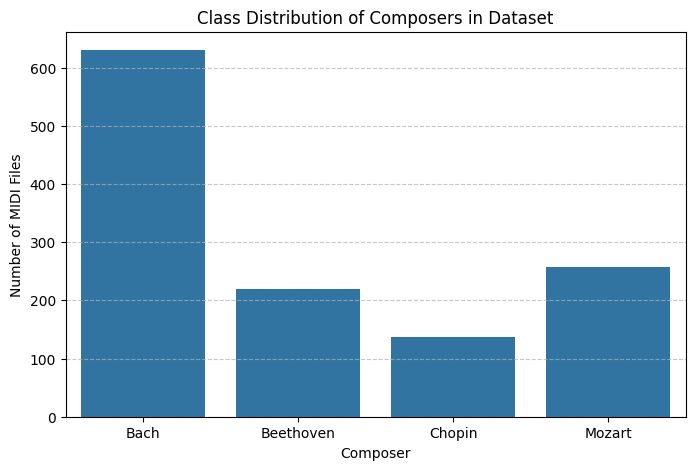

In [20]:
# Plot class distribution before splitting
plt.figure(figsize=(8, 5))
sns.countplot(data=features_df, x='composer', order=composers)
plt.title("Class Distribution of Composers in Dataset")
plt.xlabel("Composer")
plt.ylabel("Number of MIDI Files")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1244.000000       1244.000000   1244.000000   1218.000000   
mean       243.485951          5.375402   3542.494373     13.437448   
std        315.451707          4.989747   5223.651718      8.148782   
min          0.000000          0.000000      0.000000      3.616134   
25%         45.000000          2.000000    427.500000      8.154167   
50%        121.847917          4.000000   1449.000000     10.927827   
75%        309.437500          6.000000   4642.000000     15.950886   
max       4482.375000         40.000000  46897.000000     69.022285   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1218.000000  1218.000000  1218.000000  1218.000000   1218.000000   
mean       80.631289    34.468801    85.453202    63.209217     64.673235   
std        18.780766     6.519632     7.278125     3.149235      6.784992   
min        30.812865     9.000000

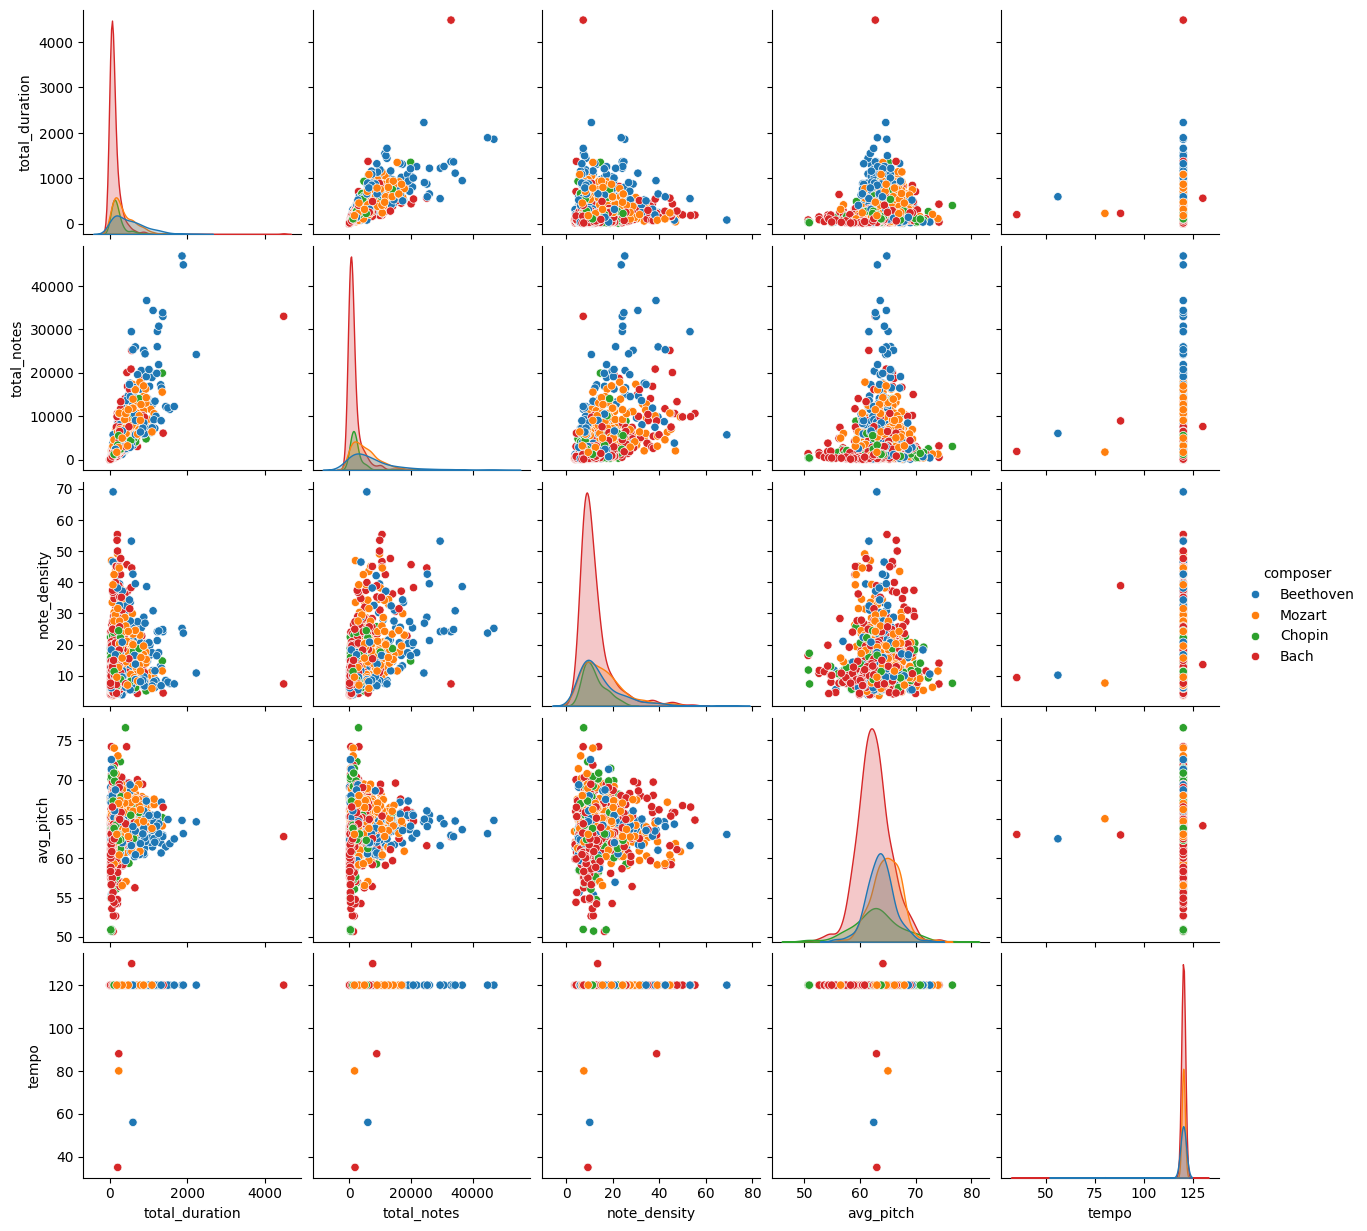

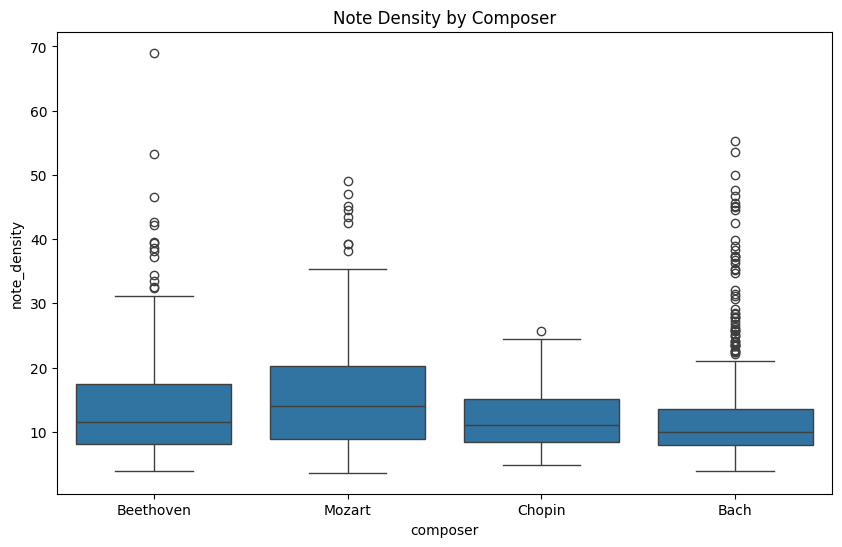

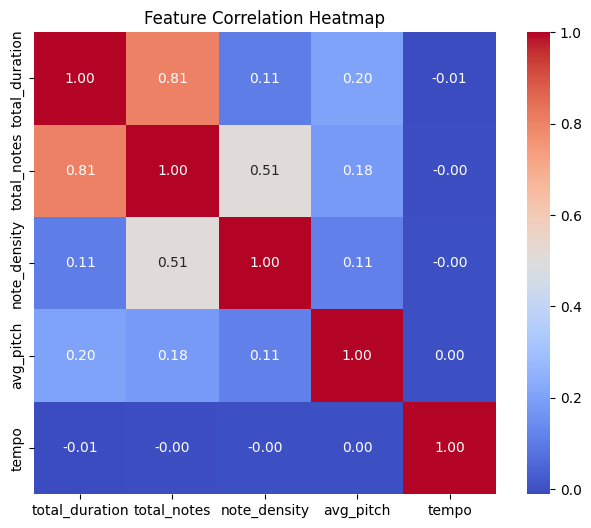

In [21]:
def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

run_exploratory_data_analysis(features_df)


# **Explore Note Sequences specifically**
These sequential features will be cused for LSTM and CNN analysis.

Number of valid sequences: 1218
Mean sequence length (number of notes): 3618.114121510673
Median sequence length 1495.5
Min sequence length: 83
Max sequence length: 46897


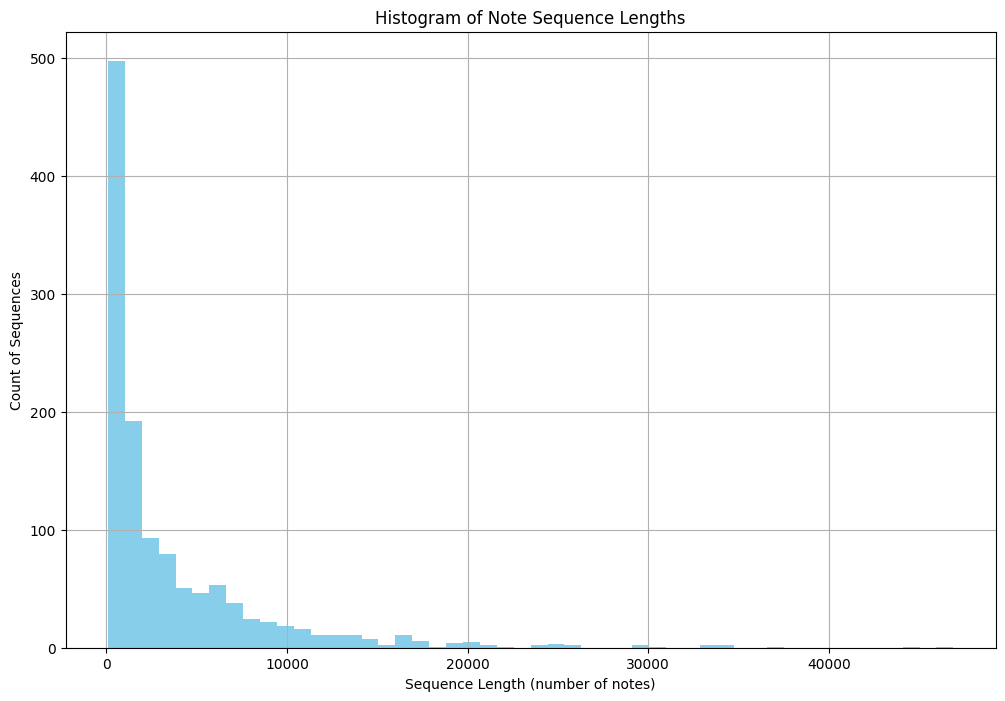

In [22]:
# Extract note sequences
note_seqs = features_df['note_seq']

# Keep only valid sequences (numpy arrays with shape (N, 4))
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

# Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
median_length = np.median(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Median sequence length", median_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

# Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

# **Create train test split**

In [23]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,
    random_state=SEED,
    stratify=features_df['composer'] #Ensure each composer is split 80/20
)
#What is the counts of data in each folder, train, test, validation?
print(train_df.shape)
print(test_df.shape)

(995, 24)
(249, 24)


# **Model Building - LSTM**

In [24]:
def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    X_seq_data = [] # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    y_labels_seq = [] # Initialize a list to store label indices corresponding to composers.

    composer_idx_mapping = {name: idx for idx, name in enumerate(composers)} # Create a mapping of composer names to numeric indices for classification.

    for index, row in input_df.iterrows(): # Iterate over each MIDI file (row) in the input dataframe.

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]      # shape (n_notes, 3)
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  # shape (2,) added to try and improve composer differentiation
        composer_label = row['composer']

        # Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  # shape (n_notes, 2)

        # Concatenate along the last axis (columns) -> shape (n_notes, 5)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  # 4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if full_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = full_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[composer_label])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 6 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(composers))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot

def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # First LSTM layer: must return sequences to pass to the next LSTM layer
    lstm_net.add(layers.LSTM(64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    #See if dropout enhances performance
    lstm_net.add(layers.Dropout(0.2))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))


    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.


    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    lstm_net.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',   #
      metrics=['accuracy']
    )

    # Return the constructed LSTM classifier model.
    return lstm_net

In [25]:
print(" Preparing LSTM data...")

# Filter out rows with unexpected note_seq shapes before creating sequences
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()


# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_df_filtered, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_df_filtered, target_length=500)

 Preparing LSTM data...


### Training LSTM model

In [26]:
print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(composers))
print(" Save LSTM Model...")
lstm_model_final.save("lstm_model.keras")

# Define early stopping callback: monitors val_loss, stops if no improvement after e.g., ?? epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=50,              # number of epochs with no improvement
    restore_best_weights=True # restores weights from best epoch
)

# To log learning rate
class LRTensorBoard(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Try both attribute names for compatibility
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'learning_rate'):
            lr = optimizer.learning_rate
        else:
            lr = optimizer.lr
        logs['lr'] = float(tf.keras.backend.get_value(lr))
lr_logger = LRTensorBoard()


# Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, lr_logger],
)



 Training LSTM model...
 Save LSTM Model...
Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4622 - loss: 1.3594 - val_accuracy: 0.5282 - val_loss: 1.1306 - lr: 0.0010
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5204 - loss: 1.1127 - val_accuracy: 0.5128 - val_loss: 1.1071 - lr: 0.0010
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5392 - loss: 1.0807 - val_accuracy: 0.5385 - val_loss: 1.1057 - lr: 0.0010
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5424 - loss: 1.0844 - val_accuracy: 0.5385 - val_loss: 1.0999 - lr: 0.0010
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.5511 - loss: 1.0776 - val_accuracy: 0.5436 - val_loss: 1.0918 - lr: 0.0010
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5738 - loss: 1.0749 - val_accuracy: 0.5487 - val_loss: 1.0795 - lr: 0.0010
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5566 - loss: 1.0572 - val_accuracy: 0

##TEMP - Notes on Run Performance:
1. 7.21 - 10:16 - With normalization, 300 epochs, 50 patience, .75 accuracy.

2. 7.21 - 11:13 - Without normalization, stopped at 200 epochs, patience 50, .92 accuracy.

3. 7.21 - 12:02 - Remove lower bound, without normalization, maxed at 155 epochs, patience at 40. (adjusted patience back to 50 before save to see what happens)

4. 7/26 - 9:00 - added code to ensure 80% of each composer was splite for train, and 20% for test. All else the same. .92+ on training accuracy.

# **Evaluation - LSTM**

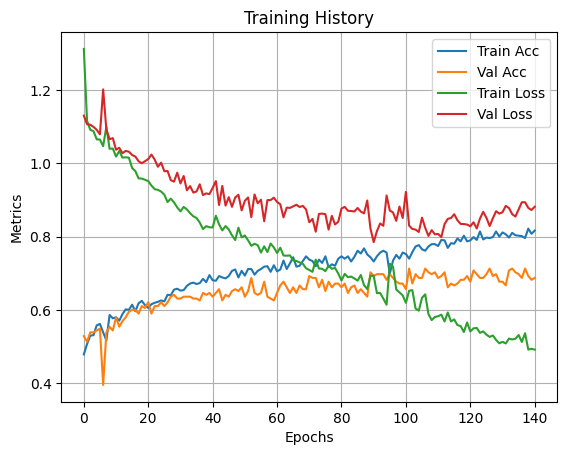

In [27]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6948 - loss: 0.8251
LSTM - Final Test Loss: 0.8966
LSTM - Final Test Accuracy: 0.6502
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
              precision    recall  f1-score   support

        Bach       0.79      0.89      0.84       123
   Beethoven       0.49      0.39      0.43        44
      Chopin       0.37      0.26      0.30        27
      Mozart       0.49      0.49      0.49        49

    accuracy                           0.65       243
   macro avg       0.53      0.51      0.52       243
weighted avg       0.63      0.65      0.63       243



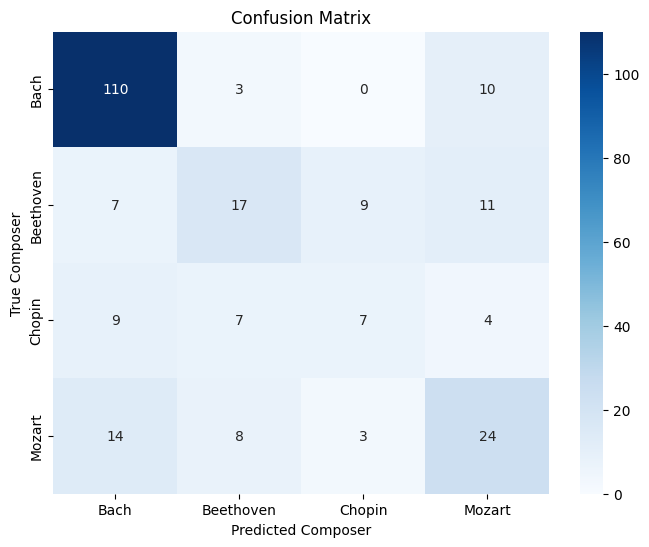

In [28]:
# Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

#Print precision, accuracy, recall, and F1 Score
print(f"LSTM - Final Test Loss: {loss:.4f}")
print(f"LSTM - Final Test Accuracy: {accuracy:.4f}")


# Evaluate the model and predict classes
# y_test: true labels (one-hot encoded or integer-encoded)
# model: your trained LSTM

# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=composers))

# Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=composers, yticklabels=composers)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

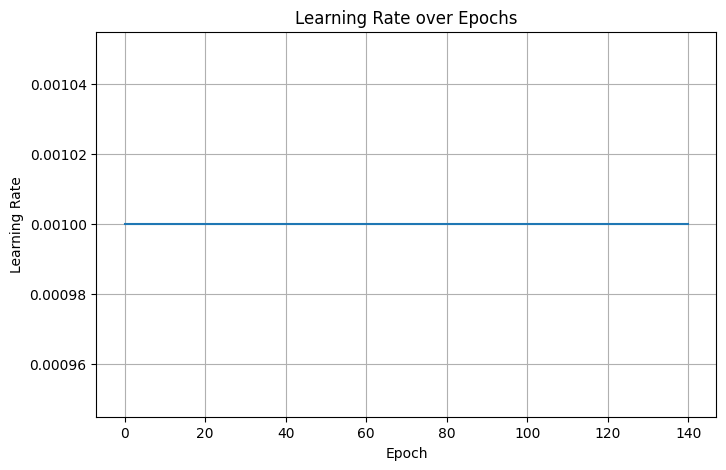

In [29]:
def plot_learning_rate(history):
    """
    Plots the learning rate over epochs if recorded in history.
    """
    if 'lr' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['lr'])
        plt.title('Learning Rate over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.show()
    else:
        print("Learning rate not recorded in history.")

plot_learning_rate(history)

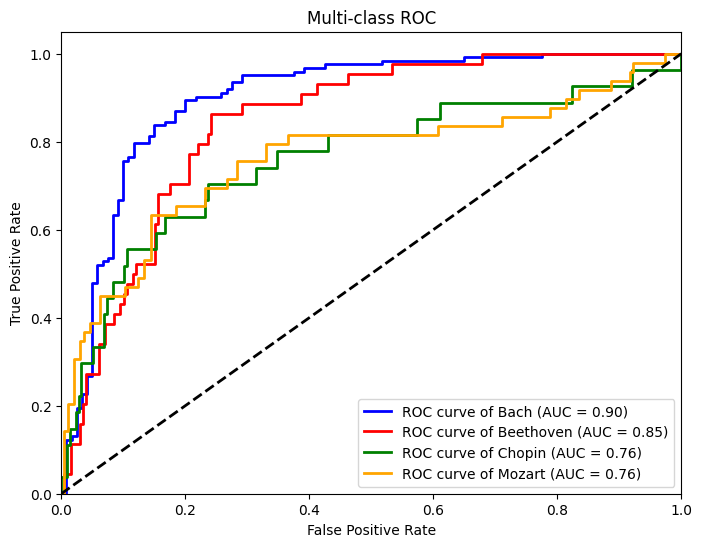

In [30]:
def plot_multiclass_roc(y_true, y_score, n_classes, class_names):
    """
    Plots ROC curves for a multi-class problem.
    y_true: one-hot encoded labels
    y_score: predicted probabilities
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

y_true_onehot = to_categorical(y_true, num_classes=len(composers))

plot_multiclass_roc(
    y_true=y_true_onehot,
    y_score=y_pred_proba,
    n_classes=len(composers),
    class_names=composers
)

# Model Summary - LSTM

In [31]:
lstm_model_final.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,790 (264.81 KB)

 Trainable params: 22,596 (88.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,194 (176.54 KB)

# **CNN Model**

# Loading data and pre procesing

In [32]:

# ----------------------------------------
# Step 1: MIDI File Collection
# ----------------------------------------
def get_midi_files(data_dir, composers):
    all_paths = []
    for composer in composers:
        folder = os.path.join(data_dir, composer)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.mid', '.midi'))]
        for file in files:
            all_paths.append((file, composer))
    return pd.DataFrame(all_paths, columns=['filepath', 'composer'])

# ----------------------------------------
# Step 2: MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()
    # Safe helpers for empty lists
    def safe_min(x, default=np.nan): return np.min(x) if len(x) else default
    def safe_max(x, default=np.nan): return np.max(x) if len(x) else default
    def safe_mean(x, default=np.nan): return np.mean(x) if len(x) else default
    def safe_std(x, default=0.0): return np.std(x) if len(x) > 1 else 0.0
    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }

def extract_statistics_dataframe(df):
    stats = []
    for _, row in df.iterrows():
        try:
            feats = extract_note_statistics(row['filepath'])
            feats['composer'] = row['composer']
            stats.append(feats)
        except Exception as e:
            print(f"Error in stats for {row['filepath']}: {e}")
    return pd.DataFrame(stats)

# ----------------------------------------
# Step 3: Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)

    # Base piano roll
    pr = midi.get_piano_roll(fs=fs)  # (128, T0)
    base_T = pr.shape[1] if pr.ndim == 2 else 0

    # Per-instrument rolls (may be empty)
    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    inst_T = max((r.shape[1] for r in instrument_rolls), default=0)

    # Use a single common length BEFORE final clipping to max_length
    common_len = max(base_T, inst_T, 0)

    # Binary & velocity rolls from base pr
    binary_roll   = (pr > 0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)
    velocity_roll = (pr / 127.0).astype(np.float32) if base_T > 0 else np.zeros((128, 0), dtype=np.float32)

    # Pad both to common_len
    def pad_to(arr, L):
        return np.pad(arr, ((0,0),(0, max(0, L - arr.shape[1]))), mode='constant')

    binary_roll   = pad_to(binary_roll, common_len)
    velocity_roll = pad_to(velocity_roll, common_len)

    # Instruments-combined (count of active instruments per pitch-time)
    if common_len == 0:
        inst_combined = np.zeros((128, 0), dtype=np.float32)
    else:
        inst_combined = np.zeros((128, common_len), dtype=np.float32)
        for r in instrument_rolls:
            if r.ndim != 2:
                continue
            r = pad_to(r, common_len)
            inst_combined += (r > 0).astype(np.float32)
        m = inst_combined.max()
        if m > 0:
            inst_combined = (inst_combined / m).astype(np.float32)

    # Expressive (note spans)
    expressive_roll = np.zeros((128, common_len), dtype=np.float32)
    if common_len > 0:
        for instr in midi.instruments:
            for note in instr.notes:
                s = int(note.start * fs)
                e = int(note.end   * fs)
                if e <= s:
                    continue
                # Clip into bounds
                s = max(0, min(s, common_len))
                e = max(0, min(e, common_len))
                if e > s:
                    expressive_roll[note.pitch, s:e] = 1.0

    # Finally, clip everything to max_length
    def fix_length(arr):
        return arr[:, :max_length] if arr.shape[1] >= max_length else np.pad(arr, ((0,0),(0, max_length - arr.shape[1])))

    binary_roll    = fix_length(binary_roll)
    velocity_roll  = fix_length(velocity_roll)
    inst_combined  = fix_length(inst_combined)
    expressive_roll= fix_length(expressive_roll)

    # Stack channels -> (128, max_length, 4)
    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1).astype(np.float32)


# ----------------------------------------
# Step 4: Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=150, limit_per_split=None):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(composers)}
    ok, bad = 0, 0

    # Optional: small slice for debugging (e.g., 50 files)
    if limit_per_split is not None:
        df = df.sample(n=min(limit_per_split, len(df)), random_state=42).reset_index(drop=True)

    for _, row in df.iterrows():
        try:
            roll  = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])

            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
            ok += 1

        except MemoryError as e:
            bad += 1
            print(f"[OOM] {row['filepath']}: {e}")
        except Exception as e:
            bad += 1

    if ok == 0:
        raise ValueError("No samples were successfully processed. Check file paths and feature functions.")


    return (np.array(X_roll,  dtype=np.float32),
            np.array(X_stats, dtype=np.float32),
            to_categorical(np.array(y), num_classes=len(composers)))


# ----------------------------------------
# Step 5: Split Dataset
# ----------------------------------------
def stratified_split_dataframe(df, label_col='composer', test_size=0.2, val_size=0.1, random_state=42):
    label_map = {label: idx for idx, label in enumerate(sorted(df[label_col].unique()))}
    y = df[label_col].map(label_map).values
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(test_size + val_size), random_state=random_state)
    for train_idx, temp_idx in sss1.split(df, y):
        train_df, temp_df = df.iloc[train_idx], df.iloc[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (test_size + val_size), random_state=random_state)
    y_temp = temp_df[label_col].map(label_map).values
    for val_idx, test_idx in sss2.split(temp_df, y_temp):
        val_df, test_df = temp_df.iloc[val_idx], temp_df.iloc[test_idx]
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

# ----------------------------------------
# Step 6: Model Building (Hybrid CNN + MLP)
# ----------------------------------------
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------------------
# Step 7: Class Weights
# ----------------------------------------
def compute_class_weights(y_train_onehot):
    y_int = np.argmax(y_train_onehot, axis=1)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

# ----------------------------------------
# Step 8: Training Wrapper
# ----------------------------------------
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       X_roll_val, X_stats_val, y_val, epochs=20, batch_size=32):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        validation_data=({'roll_input': X_roll_val, 'stats_input': X_stats_val}, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return model


# Load Data

In [33]:

df_cnn = get_midi_files(MIDI_DATA_DIR, composers)
df_cnn = df_cnn[df_cnn['filepath'].apply(os.path.exists)]  # Just to be safe
df_cnn = df_cnn.reset_index(drop=True)

# Split into Train/Val/Test

In [34]:

train_df, val_df, test_df = stratified_split_dataframe(df_cnn)

# Extract Features: Multichannel Piano Roll + Statistics


In [35]:

print("Extracting training data...")
X_train_roll, X_train_stats, y_train = create_combined_dataset(train_df)
print("Extracting validation data...")
X_val_roll, X_val_stats, y_val = create_combined_dataset(val_df)
print("Extracting test data...")
X_test_roll, X_test_stats, y_test = create_combined_dataset(test_df)

Extracting training data...


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Extracting validation data...
Extracting test data...


# Build Hybrid Model

In [36]:
input_shape_roll = X_train_roll.shape[1:]    # (128, 150, 4)
input_shape_stats = X_train_stats.shape[1]   # e.g., 10

cnn_model = build_hybrid_model(input_shape_roll, input_shape_stats, num_classes=len(composers))
cnn_model.save('cnn_raw_model.keras')

# Train and Evaluate CNN Model

In [37]:

trained_model = train_hybrid_model(cnn_model,
                                   X_train_roll, X_train_stats, y_train,
                                   X_val_roll, X_val_stats, y_val)
trained_model.save('cnn_trained_model.keras')

test_loss, test_acc = trained_model.evaluate(
    {'roll_input': X_test_roll, 'stats_input': X_test_stats}, y_test, verbose=0
)
print(f" Final Test Accuracy: {test_acc:.2%}")

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step - accuracy: 0.3613 - loss: 2.1755 - val_accuracy: 0.6871 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 799ms/step - accuracy: 0.5984 - loss: 1.2314 - val_accuracy: 0.6871 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 757ms/step - accuracy: 0.6142 - loss: 1.2322 - val_accuracy: 0.7117 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 771ms/step - accuracy: 0.6756 - loss: 1.1426 - val_accuracy: 0.7546 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 824ms/step - accuracy: 0.6824 - loss: 1.0529 - val_accuracy: 0.7607 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 737ms/step - accuracy: 0.6991 - loss: 1.0046 - val_accuracy: 0.7546 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 757ms/step - accuracy: 0.6969 - loss: 0.

# Model Summary

In [38]:
trained_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ roll_input          │ (None, 128, 150,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 150,  │      1,184 │ roll_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 37,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stats_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 75776)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        704 │ stats_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75840)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  9,707,648 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,185,646 (111.33 MB)

 Trainable params: 9,728,548 (37.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,457,098 (74.22 MB)